In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import KShape
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed, dump, load
from tslearn.preprocessing import TimeSeriesResampler
import os

# 설정

# 원본 데이터 경로
ORIGINAL_DATA_PATH = './dataset/preprocessed_training_dataset.npy'
# 다운샘플링된 데이터를 저장할 경로
DOWNSAMPLED_DATA_PATH = './dataset/preprocessed_downsampled.npy'
# 병렬 처리를 위한 임시 데이터 파일
TEMP_DATA_PATH = './dataset/temp_data_for_parallel.mmap'

# 빠른 테스트용 설정
QUICK_TEST_SIZE = 1000
QUICK_TEST_K_RANGE = range(2, 5) # K = 2,3,4만 테스트

# 본격적인 탐색용 설정
SAMPLE_FRACTION = 0.1 # 전체 데이터의 일부만 사용
FULL_K_RANGE = range(2, 16)

X_train = np.load(ORIGINAL_DATA_PATH)

# 데이터 타입을 float32로 변환하여 메모리 사용량 절감
if X_train.dtype != 'float32':
    print(f"Converting data type from {X_train.dtype} to float32...")
    X_downsampled = X_train.astype('float32')

Converting data type from float64 to float32...


In [ ]:
# 다운샘플링 및 저장
print("--- Step 1: Downsampling and Saving Data ---")

# 10분 단위로 다운샘플링 (1440 -> 144)
resampler = TimeSeriesResampler(sz=X_train.shape[1] // 10)
X_resampled = resampler.fit_transform(X_train)

--- Step 1: Downsampling and Saving Data ---


In [3]:
np.save(DOWNSAMPLED_DATA_PATH, X_resampled)

print("--- Loading and Preparing Data ---")
X_downsampled = np.load(DOWNSAMPLED_DATA_PATH)

del X_train, X_resampled

--- Loading and Preparing Data ---


In [ ]:
# K 탐색에 사용할 최종 데이터 (메모리 매핑을 위해 저장)
dump(X_downsampled, TEMP_DATA_PATH)

['./dataset/temp_data_for_parallel.mmap']

In [ ]:
# 병렬 작업을 위한 함수 정의
def calculate_kshape_metrics(k, data_path):
    # 메모리 매핑 모드로 데이터 로드하여 메모리 복제 방지
    data_mmap = load(data_path, mmap_mode='r')
    # 데이터 차원 축소
    if data_mmap.ndim == 3 and data_mmap.shape[2] == 1:
        data_2d = data_mmap.squeeze(axis=2)
        print(f"Reshaped X_quick_test to: {data_2d.shape}")
    print(f"calculate_kshape_metrics: Loaded data shape: {data_2d.shape} for k={k}")

    # tslearn은 3D 배열을 요구하므로 차원 확장
    data_3d = data_2d.reshape(data_2d.shape[0], data_2d.shape[1], 1)
    print(f"calculate_kshape_metrics: Reshaped data to 3D: {data_3d.shape} for k={k}")

    try:
        model = KShape(n_clusters=k, n_init=1, max_iter=30, random_state=42, verbose=-1)
        labels = model.fit_predict(data_3d)
        inertia = model.inertia_

        score = -1 # 기본값
        if len(np.unique(labels)) > 1:
            # 원본 데이터(2D)와 유클리드 거리를 사용해 점수 계산
            score = silhouette_score(data_2d, labels, metric='euclidean')
 
        return (k, inertia, score)
    except Exception as e:
        print(f"Error calculating for k={k}: {e}")
        return (k, None, None)

In [ ]:
# 빠른 테스트 실행 (병렬 처리 없이 디버깅 모드로)
print("\n--- Step 2: Quick Test Run (DEBUG MODE - NO PARALLELISM) ---")
X_downsampled = np.load(DOWNSAMPLED_DATA_PATH)
    
X_quick_test = X_downsampled[:QUICK_TEST_SIZE]
dump(X_quick_test, TEMP_DATA_PATH)

print(f"Running a quick test with {QUICK_TEST_SIZE} samples for K={list(QUICK_TEST_K_RANGE)}...")

# Parallel() 대신 간단한 for 루프 사용
test_results = []
for k in QUICK_TEST_K_RANGE:
    print(f"Testing k={k}...")
    # 수정된 함수를 직접 호출하여 오류가 발생하는지 확인합니다.
    result = calculate_kshape_metrics(k, TEMP_DATA_PATH)
    test_results.append(result)

print("✅ Quick test completed. Results:", test_results)

os.remove(TEMP_DATA_PATH) # 임시 파일 삭제


--- Step 2: Quick Test Run (DEBUG MODE - NO PARALLELISM) ---
Running a quick test with 1000 samples for K=[2, 3, 4]...
Testing k=2...
Reshaped X_quick_test to: (1000, 144)
calculate_kshape_metrics: Loaded data shape: (1000, 144) for k=2
calculate_kshape_metrics: Reshaped data to 3D: (1000, 144, 1) for k=2
0.213 --> 0.187 --> 0.175 --> 0.160 --> 0.159 --> 0.159 --> 0.159 --> 
Testing k=3...
Reshaped X_quick_test to: (1000, 144)
calculate_kshape_metrics: Loaded data shape: (1000, 144) for k=3
calculate_kshape_metrics: Reshaped data to 3D: (1000, 144, 1) for k=3
0.177 --> 0.131 --> 0.111 --> 0.104 --> 0.102 --> 0.101 --> 0.101 --> 0.101 --> 
Testing k=4...
Reshaped X_quick_test to: (1000, 144)
calculate_kshape_metrics: Loaded data shape: (1000, 144) for k=4
calculate_kshape_metrics: Reshaped data to 3D: (1000, 144, 1) for k=4
0.165 --> 0.118 --> 0.103 --> 0.091 --> 0.091 --> 0.091 --> 
✅ Quick test completed. Results: [(2, np.float64(0.15934327783871816), np.float64(0.14282791515836005))

## 최적 K 탐색

In [ ]:
# 본격적인 최적 K 탐색
print(f"\n--- Step 3: Full Optimal K Search (on {SAMPLE_FRACTION}% sample) ---")

# 다운샘플링된 데이터의 N%를 무작위로 샘플링
sample_size = int(len(X_downsampled) * SAMPLE_FRACTION)
sample_indices = np.random.choice(len(X_downsampled), sample_size, replace=False)
X_sample = X_downsampled[sample_indices]
dump(X_sample, TEMP_DATA_PATH) # 본격 탐색용 샘플 데이터를 임시 파일로 저장

print(f"Running full search with {sample_size} samples for K={list(FULL_K_RANGE)}...")
results = Parallel(n_jobs=7)(
    delayed(calculate_kshape_metrics)(k, TEMP_DATA_PATH) for k in tqdm(FULL_K_RANGE, desc="Dispatching K-value jobs")
)


--- Step 3: Full Optimal K Search (on 0.1% sample) ---
Running full search with 28268 samples for K=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]...


Dispatching K-value jobs: 100%|██████████| 14/14 [02:35<00:00, 11.08s/it]


In [15]:
import os
import pickle

# output 폴더가 없으면 생성
output_folder = './output'
os.makedirs(output_folder, exist_ok=True)

# results를 pickle 파일로 저장
results_file_path = os.path.join(output_folder, 'optimal_k_shape_10%.pkl')
with open(results_file_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {results_file_path}")

Results saved to ./output\optimal_k_shape_10%.pkl



--- Step 4: Processing and Visualizing Results ---


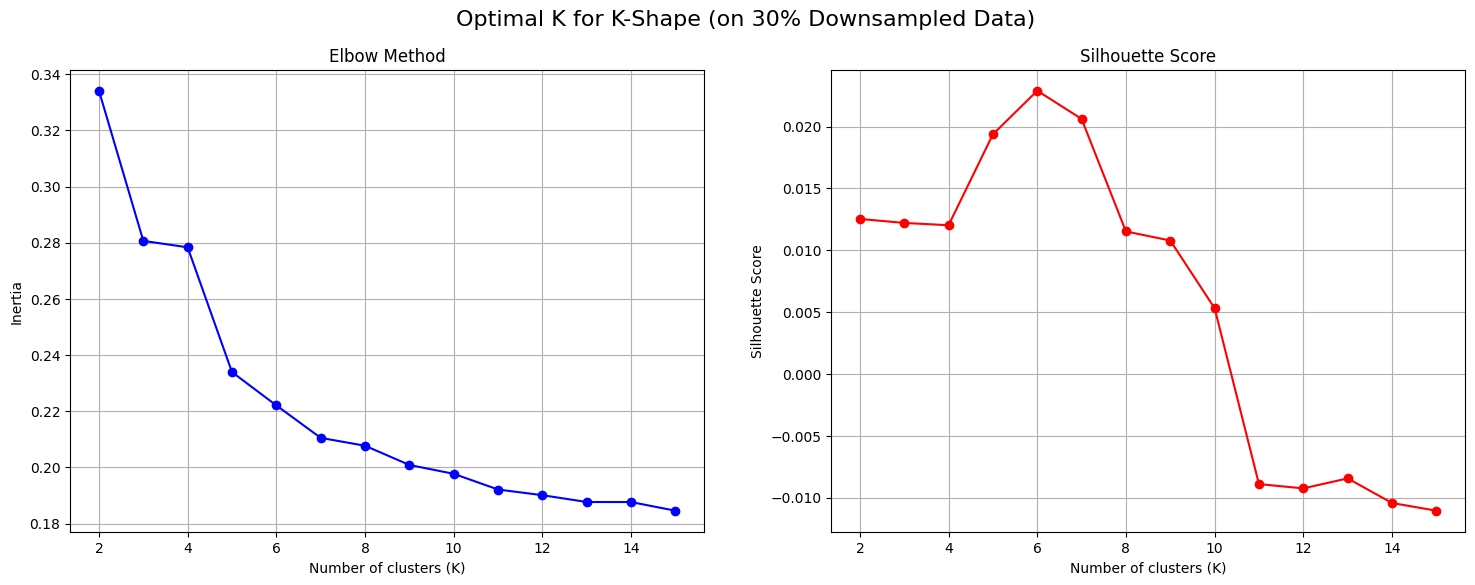

In [ ]:
# 결과 취합 및 시각화
print("\n--- Step 4: Processing and Visualizing Results ---")
results.sort(key=lambda x: x[0])
valid_results = [res for res in results if res[1] is not None and res[2] is not None]

k_values = [res[0] for res in valid_results]
inertia_values = [res[1] for res in valid_results]
silhouette_scores = [res[2] for res in valid_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Optimal K for K-Shape (on 30% Downsampled Data)', fontsize=16)

ax1.plot(k_values, inertia_values, 'bo-')
ax1.set_xlabel('Number of clusters (K)'); ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method'); ax1.grid(True)

ax2.plot(k_values, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (K)'); ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score'); ax2.grid(True)

plt.show()

## K-Shape 학습

In [ ]:
from tslearn.clustering import KShape
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pickle

# --- K=6로 K-Shape 학습 ---
print("\n--- Step: Training K-Shape with K=6 on Full Data ---")
k = 6

# K-Shape 모델 초기화
model = KShape(n_clusters=k, n_init=1, max_iter=10, random_state=42, verbose=1)

# 데이터 차원 축소 (3D -> 2D)
X_2d = X_downsampled.squeeze(axis=2)

# 학습 및 클러스터링
labels = model.fit_predict(X_downsampled)

# --- 모델 저장 ---
output_model_path = './output/kshape_model_k6.pkl'
with open(output_model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Trained K-Shape model saved to {output_model_path}")


--- Step: Training K-Shape with K=6 on Full Data ---
0.239 --> 0.228 --> 0.225 --> 0.223 --> 0.222 --> 0.221 --> 0.220 --> 0.219 --> 0.218 --> 0.217 --> 
Trained K-Shape model saved to ./output/kshape_model_k6.pkl


In [ ]:
import numpy as np
import os
from joblib import load  # pickle 대신 joblib 사용을 권장합니다
from tqdm import tqdm

# 설정

# 이전에 학습하고 저장해 둔 K-Shape 모델 경로
# (pickle로 저장하셨다면 확장자를 .pkl로, joblib이면 .joblib으로 수정)
MODEL_PATH = './output/kshape_model_k6.pkl'

# 분할할 원본 전체 데이터셋 경로
FULL_DATASET_PATH = './dataset/preprocessed_training_dataset.npy'

# K개의 데이터셋을 저장할 출력 디렉토리
OUTPUT_DIR = './clustered_datasets'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# 모델 및 전체 데이터 로드
print("--- Step 1: Loading trained model and full dataset ---")

# 저장된 K-Shape 모델 불러오기
try:
    model = load(MODEL_PATH)
except FileNotFoundError:
    print(f"🔴 ERROR: Model file not found at {MODEL_PATH}")
    exit()

# K 값은 모델 객체에서 직접 가져올 수 있습니다.
K = model.n_clusters
print(f"✅ Model loaded successfully. Number of clusters (K) is {K}.")

--- Step 1: Loading trained model and full dataset ---
✅ Model loaded successfully. Number of clusters (K) is 6.


In [ ]:
# 전체 데이터셋을 메모리 매핑 모드로 로드하여 메모리 사용량 최소화
# 파일 전체를 RAM에 올리지 않고 필요한 부분만 접근함
try:
    full_data = np.load(FULL_DATASET_PATH, mmap_mode='r')
    print(f"✅ Full dataset loaded successfully. Shape: {full_data.shape}")
except FileNotFoundError:
    print(f"🔴 ERROR: Dataset file not found at {FULL_DATASET_PATH}")
    exit()

✅ Full dataset loaded successfully. Shape: (282684, 1440, 1)


In [ ]:
# 전체 데이터에 대한 클러스터 라벨 예측
print("\n--- Step 2: Predicting cluster labels for the entire dataset ---")
# 모델의 predict 메소드를 사용하여 각 데이터 포인트의 클러스터 ID를 예측
labels = model.predict(full_data)
print("✅ Label prediction complete.")


--- Step 2: Predicting cluster labels for the entire dataset ---
✅ Label prediction complete.


In [ ]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# 단일 패스로 데이터 분할 및 저장
print(f"\n--- Step 3: Splitting and saving data into {K} separate files (Optimized Single-Pass) ---")

# 1) 각 클러스터별로 Parquet 파일을 쓰기 위한 writer 객체를 미리 생성
parquet_writers = {}
columns = [f'feature_{i}' for i in range(full_data.shape[1])]

# 데이터 차원 축소 (3D -> 2D)
if full_data.ndim == 3 and full_data.shape[2] == 1:
    full_data = full_data.squeeze(axis=2)
    print(f"Reshaped full_data to: {full_data.shape}")
    
schema = pa.Table.from_pandas(pd.DataFrame([full_data[0]], columns=columns)).schema

for k in range(K):
    output_path = os.path.join(OUTPUT_DIR, f'cluster_{k}_data.parquet')
    parquet_writers[k] = pq.ParquetWriter(output_path, schema=schema)

# 2) 데이터를 배치 단위로 순회하며, 각 데이터를 맞는 writer에 쓰기
batch_size = 5000
num_batches = int(np.ceil(len(full_data) / batch_size))

for i in tqdm(range(num_batches), desc="Splitting and Writing Batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(full_data))
    
    # 현재 배치에 대한 데이터와 라벨
    batch_data = full_data[start_idx:end_idx]
    batch_labels = labels[start_idx:end_idx]
    
    # 배치를 DataFrame으로 만들고 라벨 추가
    df_batch = pd.DataFrame(batch_data, columns=columns)
    df_batch['cluster_label'] = batch_labels
    
    # cluster_label로 그룹화하여 내부 루프 대체
    for cluster_id, group_df in df_batch.groupby('cluster_label'):
        # 원본 데이터만 다시 추출 (cluster_label 컬럼 제외)
        group_data_only = group_df.drop(columns=['cluster_label'])
        
        if not group_data_only.empty:
            table_chunk = pa.Table.from_pandas(group_data_only, schema=schema)
            # 해당하는 writer에 쓰기
            parquet_writers[cluster_id].write_table(table_chunk)

# 3) 모든 writer 객체 닫기
for writer in parquet_writers.values():
    writer.close()

print(f"\n🎉 All data has been efficiently split into {K} Parquet datasets!")


--- Step 3: Splitting and saving data into 6 separate files (Optimized Single-Pass) ---
Reshaped full_data to: (282684, 1440)


Splitting and Writing Batches: 100%|██████████| 57/57 [00:46<00:00,  1.23it/s]



🎉 All data has been efficiently split into 6 Parquet datasets!


In [36]:
import os
import pyarrow.parquet as pq

# 저장된 Parquet 파일 경로
output_dir = './clustered_datasets'

# 1. 저장된 파일 리스트 확인
parquet_files = [f for f in os.listdir(output_dir) if f.endswith('.parquet')]
print(f"✅ Found {len(parquet_files)} Parquet files: {parquet_files}")

# 2. 각 파일의 행(row)과 열(column) 개수 확인
for file in parquet_files:
    file_path = os.path.join(output_dir, file)
    table = pq.read_table(file_path)
    num_rows = table.num_rows  # 행 개수
    num_columns = table.num_columns  # 열 개수
    print(f"\n📂 File: {file}")
    print(f"Rows: {num_rows}, Columns: {num_columns}")

✅ Found 6 Parquet files: ['cluster_0_data.parquet', 'cluster_1_data.parquet', 'cluster_2_data.parquet', 'cluster_3_data.parquet', 'cluster_4_data.parquet', 'cluster_5_data.parquet']

📂 File: cluster_0_data.parquet
Rows: 55434, Columns: 1440

📂 File: cluster_1_data.parquet
Rows: 72728, Columns: 1440

📂 File: cluster_2_data.parquet
Rows: 56024, Columns: 1440

📂 File: cluster_3_data.parquet
Rows: 24030, Columns: 1440

📂 File: cluster_4_data.parquet
Rows: 41496, Columns: 1440

📂 File: cluster_5_data.parquet
Rows: 32972, Columns: 1440


In [37]:
# --- 지표 계산 ---
silhouette = silhouette_score(X_2d, labels, metric='euclidean')
calinski_harabasz = calinski_harabasz_score(X_2d, labels)
davies_bouldin = davies_bouldin_score(X_2d, labels)

print("\n--- Evaluation Metrics ---")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")


--- Evaluation Metrics ---
Silhouette Score: 0.0225
Calinski-Harabasz Index: 4397.9863
Davies-Bouldin Index: 12.3880
